# Run full Granual Predictions

What needs to happen:
- ~~function to temporally and spatially interpolate MERRA2~~
- ~~function to read MERRA2 with interpolation~~
  - PS = surface_pressure
  - T10M = 10-meter_air_temperature (Andy will investigate)
  - TO3 = total_column_ozone
  - TQV = total_precipitable_water_vapor
- ~~function to read VNP02MOD~~
  - in group "observation_data"
    - M14 (for center wavelengths at 8500 nm)
    - M15 (for center wavelengths at 10800 nm)
    - M16 (for center wavelengths at 12000 nm)
- ~~function to read VNP03MOD~~
  - in group "geolocation_data"
    - sensor_azimuth
    - sensor_zenith
    - solar_azimuth
    - solar_zenith
- combine above for model inputs
- check if there are any transformations that need to be made on the inputs before sening them though the model
- load the saved model (see tensorflow.keras.models.load_model as in evaluate.ipynb)
- call the saved model's "predict" method on the combined inputs

## Setup

In [11]:
from pathlib import Path
from importlib import reload

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from hot_dust import preprocess, DATADIR

In [12]:
open_vnp02 = xr.open_dataset(
    "data/granules/VNP02MOD.A2020168.1448.002.2021127084950.nc",
    group="observation_data",
    mask_and_scale=False,
)

# Access the relavant variables
vnp02_variables = open_vnp02[
    [
        "M14",
        "M14_brightness_temperature_lut",
        "M15",
        "M15_brightness_temperature_lut",
        "M16",
        "M16_brightness_temperature_lut",
    ]
]

# call xr where and fill values less than oe equal to 65527 
vnp02_variables =  xr.where(vnp02_variables >= 65527, np.nan, vnp02_variables) #TODO stack, drop nan (drop same indices from others), convert to int, unstack  

# Create a mask for the NaN values and fill them   
nan_mask = xr.where(np.isnan(vnp02_variables), True, False)
vnp02_variables = vnp02_variables.where(~nan_mask, other=-999.99)

vnp02_variables

# xr stack and unstack 3D to 2D

<xarray.Dataset>
Dimensions:                         (number_of_lines: 3232,
                                     number_of_pixels: 3200,
                                     number_of_LUT_values: 65536)
Dimensions without coordinates: number_of_lines, number_of_pixels,
                                number_of_LUT_values
Data variables:
    M14                             (number_of_lines, number_of_pixels) float64 ...
    M14_brightness_temperature_lut  (number_of_LUT_values) float32 120.0 ... ...
    M15                             (number_of_lines, number_of_pixels) float64 ...
    M15_brightness_temperature_lut  (number_of_LUT_values) float32 111.0 ... ...
    M16                             (number_of_lines, number_of_pixels) float64 ...
    M16_brightness_temperature_lut  (number_of_LUT_values) float32 103.0 ... ...

In [13]:
open_vnp03 = xr.open_dataset(
    "data/granules/VNP03MOD.A2020168.1448.002.2021125194020.nc",
    group="geolocation_data",
)

# Access the relavant variables
vnp03_variables = open_vnp03[
    ["sensor_azimuth", "sensor_zenith", "solar_azimuth", "solar_zenith"]
]

In [14]:
# Merge the model imputs
vnp02_vnp03 = xr.merge([vnp02_variables, vnp03_variables])

# Stack the model inputs (did this in the blocks of code for merra)
vnp02_vnp03.stack(stack_dim=('number_of_lines', 'number_of_pixels'))


# Drop the NaN values (didn't work)
#vnp02_vnp03 = vnp02_vnp03.dropna(dim= 'number_of_lines') 
#vnp02_vnp03 = vnp02_vnp03.dropna(dim= 'number_of_pixels') 

# Convert temperature variables to integers
vnp02_vnp03["M14"] = vnp02_vnp03["M14"].astype(int)
vnp02_vnp03["M15"] = vnp02_vnp03["M15"].astype(int)
vnp02_vnp03["M16"] = vnp02_vnp03["M16"].astype(int)

# Multiply them within the xarray 
vnp02_vnp03["M14"] = vnp02_vnp03["M14_brightness_temperature_lut"][vnp02_vnp03["M14"]]
vnp02_vnp03["M15"] = vnp02_vnp03["M14_brightness_temperature_lut"][vnp02_vnp03["M15"]]
vnp02_vnp03["M16"] = vnp02_vnp03["M14_brightness_temperature_lut"][vnp02_vnp03["M16"]]  

vnp02_vnp03

<xarray.Dataset>
Dimensions:                         (number_of_lines: 3232,
                                     number_of_pixels: 3200,
                                     number_of_LUT_values: 65536)
Dimensions without coordinates: number_of_lines, number_of_pixels,
                                number_of_LUT_values
Data variables:
    M14                             (number_of_lines, number_of_pixels) float32 ...
    M14_brightness_temperature_lut  (number_of_LUT_values) float32 120.0 ... ...
    M15                             (number_of_lines, number_of_pixels) float32 ...
    M15_brightness_temperature_lut  (number_of_LUT_values) float32 111.0 ... ...
    M16                             (number_of_lines, number_of_pixels) float32 ...
    M16_brightness_temperature_lut  (number_of_LUT_values) float32 103.0 ... ...
    sensor_azimuth                  (number_of_lines, number_of_pixels) float32 ...
    sensor_zenith                   (number_of_lines, number_of_pixels) float32 ...
    solar_azimuth                   (number_of_lines, number_of_pixels) float32 ...
    solar_zenith                    (number_of_lines, number_of_pixels) float32 ...

In [15]:
preprocess = reload(preprocess)

## Prepare Inputs

In [16]:
granule = list(sorted(Path("data/granules").glob("VNP02MOD.*")))
granule[0]

WindowsPath('data/granules/VNP02MOD.A2020168.1448.002.2021127084950.nc')

In [17]:
x = preprocess.process_granule(granule[0])

In [18]:
variables_merged = x.to_dataset("feature").unstack()

In [19]:
# open WITHOUT mask_and_scale to access observations as integers (ignore scale and offset)
open_vnp02_int = xr.open_dataset(
    DATADIR / "granules" / vnp02,
    group="observation_data",
    mask_and_scale=False,
)

# open WITH mask_and_scale to access LUT values as floats (with NaNs)
open_vnp02 = xr.open_dataset(
    DATADIR / "granules" / vnp02,
    group="observation_data",
)

# create new xr.Dataset to contain viirs_bts
vnp02_variables = xr.Dataset()
for item in ["M14", "M15", "M16"]:
    vnp02_variables[item + "_bt"] = open_vnp02[item + "_brightness_temperature_lut"][open_vnp02_int[item]]
    long_name = vnp02_variables[f"{item}_bt"].attrs["long_name"]
    vnp02_variables[item + "_bt"].attrs["long_name"] = long_name.replace(" lookup table", "")

NameError: name 'vnp02' is not defined

In [ ]:
# open (just open, no tricks here)
open_vnp03 = xr.open_dataset(
    DATADIR / "granules" / vnp03,
    group="geolocation_data",
)

# select the relavant variables
vnp03_variables = open_vnp03[["sensor_zenith", "solar_zenith"]]

# compute relative azimuth
array = np.abs(open_vnp03["solar_azimuth"] - open_vnp03["sensor_azimuth"])
vnp03_variables["relative_azimuth"] = array.where(array <= 180, 360 - array)

NameError: name 'vnp03' is not defined

In [21]:
# merge the model imputs
vnp02_vnp03 = xr.merge([vnp02_variables, vnp03_variables])
vnp02_vnp03

<xarray.Dataset>
Dimensions:                         (number_of_lines: 3232,
                                     number_of_pixels: 3200,
                                     number_of_LUT_values: 65536)
Dimensions without coordinates: number_of_lines, number_of_pixels,
                                number_of_LUT_values
Data variables:
    M14                             (number_of_lines, number_of_pixels) float64 ...
    M14_brightness_temperature_lut  (number_of_LUT_values) float32 120.0 ... ...
    M15                             (number_of_lines, number_of_pixels) float64 ...
    M15_brightness_temperature_lut  (number_of_LUT_values) float32 111.0 ... ...
    M16                             (number_of_lines, number_of_pixels) float64 ...
    M16_brightness_temperature_lut  (number_of_LUT_values) float32 103.0 ... ...
    sensor_azimuth                  (number_of_lines, number_of_pixels) float32 ...
    sensor_zenith                   (number_of_lines, number_of_pixels) float32 ...
    solar_azimuth                   (number_of_lines, number_of_pixels) float32 ...
    solar_zenith                    (number_of_lines, number_of_pixels) float32 ...

The "raw" cell below has code to read the MERRA2 files directly from AWS, so it will not run locally. The output has been commited to DVC, however, so it does not need to be re-run unless the preprocessing code changes.

In [22]:
(DATADIR / 'merra').exists() 
directory_path = (DATADIR / 'merra').glob('*.nc')  
list(directory_path)

[WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020168.1448.002.2021125194020.nc'),
 WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020169.0318.002.2021125194543.nc'),
 WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020169.1430.002.2021125195004.nc'),
 WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020170.0300.002.2021125195511.nc'),
 WindowsPath('c:/Users/micah/hot-dust/data/merra/VNP03MOD.A2020170.1412.002.2021125200321.nc')]

In [23]:
# Merge all the merra files
merra_variables = xr.open_dataset(DATADIR / 'merra' / vnp03) 

# Drop the coordinates 
merra_variables = merra_variables.drop(['time', 'lon', 'lat'])

# Divide the MERRA2 pressure by 100 to get it in the right units
merra_variables['PS'] = merra_variables['PS']/100 
merra_variables

NameError: name 'vnp03' is not defined

In [ ]:
# drop LUT values  
#vnp02_vnp03 = vnp02_vnp03.drop_vars(['M14_brightness_temperature_lut', 'M15_brightness_temperature_lut', 'M16_brightness_temperature_lut'])  


# xr stack number of lines and pixels vnp03 and vnp02 make it 1D using the stack function
#variables_merged = xr.merge([vnp02_vnp03, merra_variables], compat='override') # Merge 1st, then stack
#variables_stacked = variables_merged.stack(dims_stacked = ('number_of_lines', 'number_of_pixels'))  

vnp02_vnp03

In [ ]:
# Merge viirs and merra variables
variables_merged = xr.merge([vnp02_vnp03, merra_variables]) 

## 2D Plot of Input Variables

In [ ]:
# M14 Map
plt.imshow(variables_merged["M14_bt"], cmap="Reds", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()  

In [ ]:
# M15 Map
plt.imshow(variables_merged["M15_bt"], cmap="Greens", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

In [ ]:
# M16 Map
plt.imshow(variables_merged["M16_bt"], cmap="Blues", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

In [ ]:
# Sensor zenith angle
plt.imshow(variables_merged["sensor_zenith"], cmap="Grays", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

In [ ]:
# Surface pressure
plt.imshow(variables_merged["PS"], cmap="Grays", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

In [ ]:
# Water vapor
plt.imshow(variables_merged["TQV"], cmap="Grays", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

In [ ]:
# Wind speed
plt.imshow(variables_merged["WS"], cmap="Grays", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

In [ ]:
# Skin temperature
plt.imshow(variables_merged["TS"], cmap="Grays", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

In [ ]:
# Ozone
plt.imshow(variables_merged["TO3"], cmap="Grays", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

## Generate Predictions

In [24]:
import tensorflow as tf

In [25]:
network = tf.keras.models.load_model("data/network")

In [26]:
path = (granule[0].parents[1] / "granules-prediction")
path.mkdir(exist_ok=True)
for item in granule:
    # stack number of lines and pixels to make it a 2D array with 'sample' and 'feature'
    da = preprocess.process_granule(item)
    da = da.stack({"sample": ("number_of_lines", "number_of_pixels")}).transpose("sample", ...)
    index = da.notnull().all(dim="feature")
    # make prediction on nonnull values
    y_pred = network(da[{"sample": index}].data).numpy()
    # recover the coordinates for the outputs from inputs
    ds = xr.Dataset({
        "x": da,
        "y_pred": ("sample", np.full(da.sizes["sample"], None, dtype=y_pred.dtype)),
    })
    ds["y_pred"][{"sample": index}] = y_pred[:, 0]
    da = ds["y_pred"].unstack()
    da = da.drop(list(da.coords))
    da.to_netcdf(path / item.name)

## 2D Plot of Predicted Dust Optical Thickness

In [27]:
# Predicted Log10 Dust Optical Thickness
plt.imshow(ds["y_pred"][::-1,::-1], cmap="Grays", interpolation="none")
# Colorbar and lables
cb = plt.colorbar(shrink=0.5)
plt.show()

IndexError: too many indices

## WIP / Scratch

In [28]:
labelled = xr.open_dataset("data/rt_nn_irdust_training_data.nc")

(array([24865., 25030., 25036., 25017., 25015., 24945., 24881., 25086.,
        25206., 24919.]),
 array([3.61484010e-04, 8.00028610e+00, 1.60002098e+01, 2.40001335e+01,
        3.20000572e+01, 3.99999809e+01, 4.79999084e+01, 5.59998322e+01,
        6.39997559e+01, 7.19996796e+01, 7.99996033e+01]),
 <BarContainer object of 10 artists>)

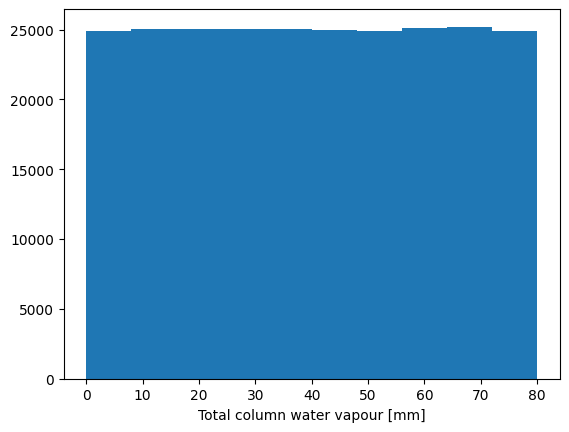

In [29]:
labelled["h2o"].plot.hist()